<a href="https://colab.research.google.com/github/musah29/Sales_Forecast_Regression_Analysis/blob/main/TIME_SERIES_FORECAST_FAVORITA_STORES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BEIJING


# **Forecasting Retail Sales using Time Series Models.**

**DESCRIPTION:**
    
The objective of this project is to develop a robust time series forecasting model that can accurately predict the unit sales for various items sold in Favorita stores. Favorita is a leading grocery retailer based in Ecuador, and the company's sales data will be used to build the model. The data set contains sales data for thousands of items sold at different stores, making it a challenging and complex problem.

To build an accurate forecasting model, various statistical and machine learning techniques will be used. The data will be preprocessed to ensure that it is clean, consistent, and in the right format for analysis. Exploratory data analysis (EDA) techniques will be employed to gain a deeper understanding of the data and identify any patterns or trends in the sales data.

Time series forecasting models, such as ARIMA, Linear regression and machine learning model-Prophet will be used to predict store sales. These models will be trained using historical sales data, and their accuracy will be evaluated using various performance metrics such as root mean square logarithmic error, root mean squared error (RMSE), and mean square error (MSE).

The results obtained from the forecasting models will be analyzed, and insights gained from the analysis will be used to make informed business decisions. The insights could include identifying which products have high demand at different times of the year, which stores perform better than others, and identifying any trends in sales data that could inform marketing and inventory decisions.

Overall, the project aims to build a reliable time series forecasting model that can help Favorita optimize their sales strategies and improve their bottom line.

**QUESTIONS ASKED OF THE DATA**

-Is the train dataset complete (has all the required dates)?

-Which dates have the lowest and highest sales for each year?

-Did the earthquake impact sales?

-Are certain groups of stores selling more products? (Cluster, city, state, type)

-Are sales affected by promotions, oil prices and holidays?

-What analysis can we get from the date and its extractable features?

-What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

Your task is to build a model that more accurately predicts the unit sales for thousands of items.

**Hypothesis**

The location of Favorita stores has an impact on the sales of specific items, and stores located in certain regions sell more of certain items compared to others. By identifying these regional trends and patterns, Favorita can optimize its store layout, product selection, and marketing strategies to better serve its customers and increase sales.

**Null Hypothesis(H0):**

There is no relationship between the location of Favorita stores and the sales of specific items.

**Alternative Hypothesis(HA):**

The location of Favorita stores has an impact on the sales of specific items.

In [1]:
!pip install summarytools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from summarytools import dfSummary
import warnings
from scipy.stats import f_oneway
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error,mean_absolute_error
warnings.filterwarnings('ignore')

DATA LOADING

In [6]:
df_holiday_events=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/holidays_events.csv')
df_oil=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/oil.csv')
df_stores=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/stores.csv')
df_transactions=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/transactions.csv')
test_set=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/test.csv')
train_set=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/train.csv')
pd.set_option('display.max_columns', None)

# **EXPLORATORY DATA ANALYSIS**

*INSPECT EACH DATASET SET SEPARATELY*

***HOLIDAY EVENTS DATASET***

In [7]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
df_holiday_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [9]:
#Convert the date datatype from object to date.
df_holiday_events['date']=pd.to_datetime(df_holiday_events.date)

In [10]:
#Check for duplicate entries.

df_holiday_events.duplicated().value_counts()

False    350
dtype: int64

In [11]:
dfSummary(df_holiday_events,is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date[datetime64[ns]],"Min: 2012-03-02Max: 2017-12-26Duration: 2,125 days",312 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACnUlEQVR4nO3bQW7aQBSA4TclIAOSLYQEOy5QqQuWHKKH7RG64ATcgB0SQkY4sTC2u+qmagBP7Idn5v/2Trz4g/F7E1PXtQAavr36BhAOYoOat1ffAJ5jjBmLyMji0mtd1x9t348NYnOAMWY8n89/xnE8a3rt+Xw+GWN+9SE4YnPDKI7j2Waz+UiSJH/2ojRNo+12OzsejyMRITY8L0mSfLFYvDe8bNzJzVjgBQFqiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qgl7E+3BGzCXBxubLGTGXBBubeHJGzCUhxyYi7p8RcwkvCFBDbFBDbFBDbFBDbFAT/Nuo78qyHIpIbIxpemnrg2ti81iWZcOiKH6sVqvBYDB4epYo0s3gmtg8dr1e36IomqzX63y5XJ6eva6rwTWxBWA6nTYeXJdlGUvLj18vYrNcqMdVVQ27uB/XdfX4dT4224V6URRRWZbf8zz/LSJN11Ve6+rx20lsykd3rBbq+/1+ttvtJrfbbdDw9wXD5vErd/bGrcf2qqM7TRfqp9OJZbqyLj7ZOLqD/+rsOxtHd/Av1lVQQ2xQ06vRh+Uej3mZI3oTm+0g0bV5WcgD6N7EZjtIdGleFvoAujex/dV0kOjYvCzoAXTvYnPBF86IxVVVDZMkOXn8B/UpYmvoK0tqXx6HtoitIdvvliL+PA5tEZslmyW1L49DWwx1oYbYoIbYoIbYoIbYoIbYoObu6CPkpTHa92lsoS+N0b57n2xBL43RvocbBP5rCW3hBQFqiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qiA1qHh4LT9M0avIDL5dLJCKSZVl0OBwmXOfevdpe96iVP5/JsuxIyBQRAAAAAElFTkSuQmCC"">",0(0.0%)
2,type[object],1. Holiday2. Event3. Additional4. Transfer5. Bridge6. Work Day,221 (63.1%)56 (16.0%)51 (14.6%)12 (3.4%)5 (1.4%)5 (1.4%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACp0lEQVR4nO3dTWoiURiF4U+RdDspEcFluAAX0YvtRbgA9yFiDdp0Jvagg0h+cJJ7KljPs4JLeFOhinvI5HK5FCRMhz4A4yE2YsRGjNiImVTVvKqehj4I9XK5XM5DH6Kl2Wq1+tV13XLog4xd3/fHyWTy+5GDm3Vdt9xut+fFYvE89GHG6nQ6/dztdsvD4fBUVY8bW1XVYrF4Xq/Xf4Y+zMjNhz5Aa14QiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2YWdX/Ky5DH2TMxvLzn/V9f9ztdssawRWX76zv+2NVvQx9jpZcC/8+Hv5a+MRImZTUk+3hf2u5LzJ4GcOYg/uaD17GMubgvtTgxZsuPuqSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI6b5umosyyHui6yrxrAc4j4bBGKsq4hp/WTzROOq6brKqopbzdZVVlW81XpdZVXFlY+6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2Ihptq6yquKtpusqqypu2SAQY11FzGdPNk8kvtyH6yqrKFp4t66yiqKVz9ZVVlF8OR91iREbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2Yd4MXQxVa+XDwYqhCC66FE2PwQowXBGJu/4z600lT13WVRRWtTbuuW242m3qd87X+v6OM2LSqaj6f/x36IDw+LwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsy0qup8Pv8Y+iA8vmnf98f9fm9RRXOuhRNjXUWMJxsxBi/EGLwQY/BCjI+6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IixriLGuooYGwRirKuI8YJAjNiIERsx/wBPzyVwlt8VrwAAAABJRU5ErkJggg=="">",0(0.0%)
3,locale[object],1. National2. Local3. Regional,174 (49.7%)152 (43.4%)24 (6.9%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmklEQVR4nO3bQWqjABiG4d9BynSjhEAOk0PMYecQ3iaEuGhLN85iumh20eAn0uc5wU94SVDyNdM0FST82voAfo6mql6r6mXrQ3bmc5qm962P2Jv2eDz+6brusPUhezKO47Vpmr+Cm6ftuu5wPp/f+77/2PqYPbjdbr+HYThcLpeXqhLbDG1VVd/3H6fT6W3rY3bkdesD9sgDAjFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZi2qr//9Ha+pC98Fkt147jeB2G4VD+o/WwcRyvVfW59R17Y4OwjA3CAo0pHym+2e75xlqRddU3VlPrsq76YjW1Puuqe57IV+SlLjFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZirKu++AzWZ131jdXUumwQ7tkgrMi6ihgPCMTM/Rn1M8Nis6Z8pm484+Epn6kbz5o75fvxr0dYzgMCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmIenvKZuvGsWVM+UzeeYYNAjCkfMf8ASryjSnuU0NwAAAAASUVORK5CYII="">",0(0.0%)
4,locale_name[object],1. Ecuador2. Quito3. Riobamba4. Guaranda5. Latacunga6. Ambato7. Guayaquil8. Cuenca9. Ibarra10. Salinas11. other,174 (49.7%)13 (3.7%)12 (3.4%)12 (3.4%)12 (3.4%)12 (3.4%)11 (3.1%)7 (2.0%)7 (2.0%)6 (1.7%)84 (24.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD/ElEQVR4nO3cTW4TWQBG0WdkRTCxFUXyYrwIFssivBsrsgcEMXEPGlDID2oi163Yfc6M2RO6VFKl97E4nU4DCh/mPgD/H2IjIzYyYi

**Observations about df_holiday_events DataFrame.**

-There are no missing values in each of the columns.

-The date column had an object data type.

-There are total of 12 transferred holidays in the transferred column.

-There are no duplicate entries in the dataset.

**Feature creation**

For ease of analysis further down the line, I decided to create stand-alone columns for day,month and year using the date column.

In [12]:
date = pd.to_datetime(df_holiday_events['date'][0])

In [13]:
#CREATE INDIVIDUAL YEAR/MONTH/DAY COLUMNS
df_holiday_events['year'] = df_holiday_events['date'].dt.year
df_holiday_events['month'] = df_holiday_events['date'].dt.month
df_holiday_events['day'] = df_holiday_events['date'].dt.day

In [14]:
df_holiday_events.head()

,date,type,locale,locale_name,description,transferred,year,month,day
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21


In [15]:
#We now set the date as the index for the DataFrame

df_holiday_events = df_holiday_events.set_index('date')

In [16]:
df_holiday_events.head()

,type,locale,locale_name,description,transferred,year,month,day
date,,,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2012,3,2
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2012,4,1
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,2012,4,12
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,2012,4,14
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,2012,4,21


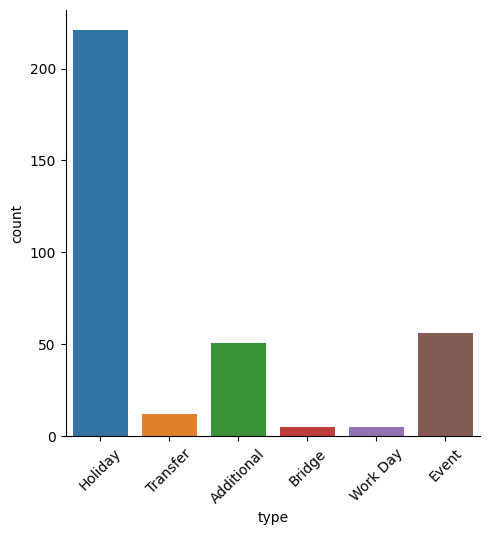

In [17]:
#Inspecting the types of the holidays column

holiday_plot = sns.catplot(data=df_holiday_events, x="type",kind="count")
holiday_plot.ax.set_xticklabels(holiday_plot.ax.get_xticklabels(), rotation=45);

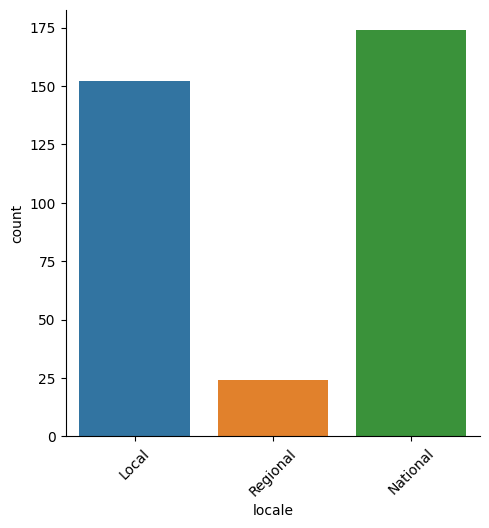

In [18]:
##Visualizing the new data set

holiday_plot = sns.catplot(data=df_holiday_events, x="locale",kind="count")
holiday_plot.ax.set_xticklabels(holiday_plot.ax.get_xticklabels(), rotation=45);


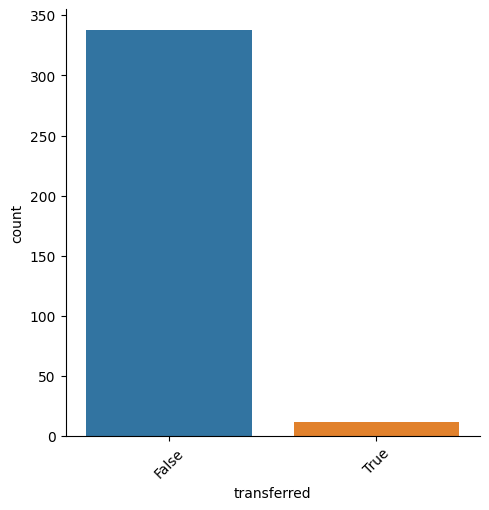

In [19]:
holiday_plot = sns.catplot(data=df_holiday_events, x="transferred",kind="count")
holiday_plot.ax.set_xticklabels(holiday_plot.ax.get_xticklabels(), rotation=45);

**OIL DATASET**

In [20]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [21]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [22]:
dfSummary(df_oil, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date[object],1. 2013-01-012. 2016-02-083. 2016-02-174. 2016-02-165. 2016-02-156. 2016-02-127. 2016-02-118. 2016-02-109. 2016-02-0910. 2016-02-0511. other,"1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1,208 (99.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,dcoilwtico[float64],Mean (sd) : 67.7 (25.6)min < med < max:26.2 < 53.2 < 110.6IQR (CV) : 49.3 (2.6),998 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC00lEQVR4nO3du27iQBSA4TNLAHORDSKCjpZipS0o/RD7sPsIQeIJaKnoEBcZwYbFGG9FgZQA9uDg4/xfP8Ea/SJxPDM2cRwLkHc/nn0BwD1enn0B1xhjaiJSSTn8EMfx+yOvB8+T21CNMbVOp/Pbdd12mvGbzWZtjPlDrMWQ21BFpOK6btv3/XfP8/ZJBgZB4IzH4/ZyuayICKEWQJ5DFRERz/P23W73b4qhtYdfDJ6GmymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChQu7PnsLXsTzmUyTDoz4JFSJif8ynSLZHfRIqzlIf8ymS/VGfhIoLFsd8imR41Cc3U1CBUKECoUIFQoUKhAoVCBUqECpUIFSowD/88TBRFJVFxDXGpBl+dZ1AYUO1nDQR3qWayG63K4dh+Kvf75dKpVLiR7C31gkUMlTbSRPhXapJHQ6HF8dx6sPhcN/r9dZJxt6zTqCQodpMmgjvUrXRaDQyeSVoIUM9s5g0Ed6lmivc9UMFQoUKmf7qt9za4J5Op/Ijr+c7sJjzXM93ZqHabm0Iw9CJoujnfr9/E5G0f2d+KzZznvf5zvIb1Wprw2w2a08mk/rxeCxlcXEFlXrO8z7fmd/1p93asF6vuetOKc2c532+uZmCCoQKFQgVKhAqVCBUqECoUOHmv6eK+qQDulwNtchPOqDLrW/Uwj7pgC53PZkq4pOOW7Lc/3MNC3k+VuiF02llvf/nMyzk+RyhfsB2/89oNOoul8tXY8wm4Ue7zWaz6/v+hoU8lwj1ijRbWWy+jc/fiNVq9Y2FPJfuCjUIAifpD95ut46IyG63c+bzef0rxz/zs1erVdNxnPpgMDCtVutfkrGLxcKZTqf1IAga8/n8kGSsiN45u6ev/0tLlBQ29uaWAAAAAElFTkSuQmCC"">",43(3.5%)


In [23]:
df_oil.duplicated().value_counts()

False    1218
dtype: int64

**Observations about df_oil DataFrame**

-There are 43 missing values in the dcoilwtico column.

-There are no duplcate entries in the DataFrame.
    
-The date column is an object data type.

In [24]:
#Change the date data type from object to date time

df_oil['date']=pd.to_datetime(df_oil.date)

**Feature creation**

For ease of analysis further down the line, I decided to create stand-alone columns for day,month and year using the date column.

In [25]:
date = pd.to_datetime(df_oil['date'][0])

In [26]:
df_oil['Year']=date.year
df_oil['Month']=date.month
df_oil['Day Name']=date.day_name()

In [27]:
#We now set the date as the index for the DataFrame

df_oil = df_oil.set_index('date')

In [28]:
df_oil.head()

,dcoilwtico,Year,Month,Day Name
date,,,,
2013-01-01,NaN,2013,1,Tuesday
2013-01-02,93.14,2013,1,Tuesday
2013-01-03,92.97,2013,1,Tuesday
2013-01-04,93.12,2013,1,Tuesday
2013-01-07,93.20,2013,1,Tuesday


<Axes: xlabel='date'>

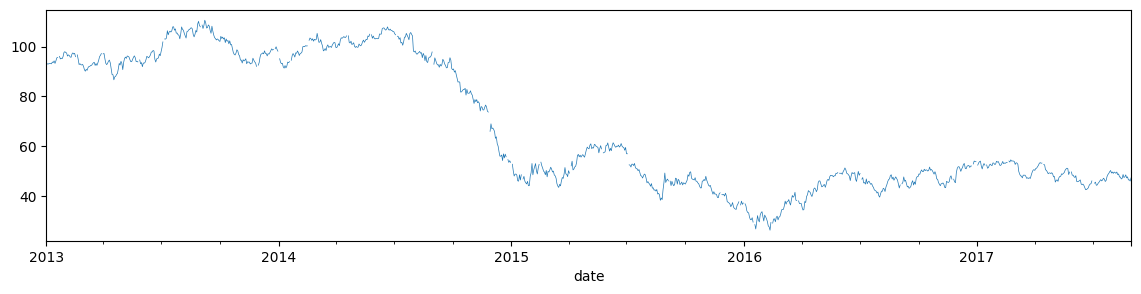

In [29]:
plt.figure(figsize=(14,3))
df_oil['dcoilwtico'].plot(linewidth=0.5)

-There are gaps in the plot that indicates missing oil price values for those points in time. The solution is to extrapolate the price for oil for the relevant dates.

-There is clearly a downward trend in oil prices when viewd across the five (5) yeas under inspection.

-Oil prices in 2013 to mid year 2014 stayed above $80 per barrel.

-The prices started trending downwards from mid 2014 and hit its lowest price at ending of February 2016.

-Price then rose to $50 a barrel in the second quarter of 2016.It has held steady since then.

<b>MISSING VALUES IN OIL DATASET<b>

In [30]:
df_oil["dcoilwtico"]=df_oil['dcoilwtico'].interpolate(method='linear')

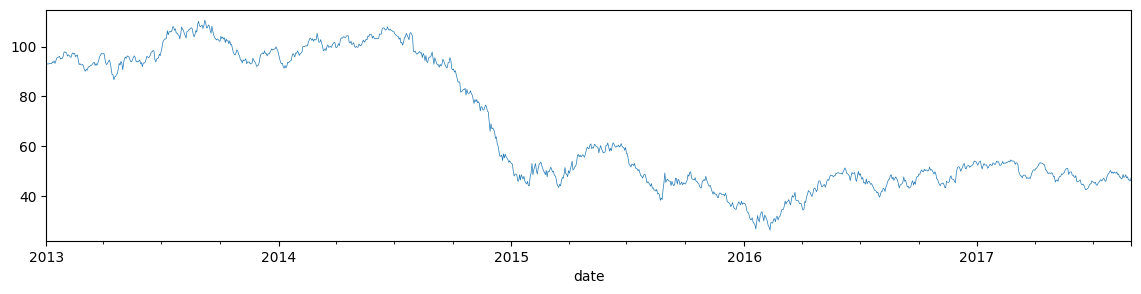

In [31]:
plt.figure(figsize=(14,3))
df_oil['dcoilwtico'].plot(linewidth=0.5);

<b>Stores Dataset<b>

In [32]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [33]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [34]:
dfSummary(df_stores, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,store_nbr[int64],Mean (sd) : 27.5 (15.7)min < med < max:1.0 < 27.5 < 54.0IQR (CV) : 26.5 (1.7),54 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACW0lEQVR4nO3ZvYoaYQCF4fP5x/jDiEi0s0kZSGHpReRicwkpvAKLNKnsBBHFyYrjaJoNbLU6Mzu6B9+n9vM7LK8rarhcLgI+u9qjBwC3aFx7QAihLalV8PmPl8vlpeDZUkrulh603XW3VG0r74YaQmgPh8MfcRwPity82+02IYSf9/7Dld0tPWa7626p+lau/UdtxXE8mM1mL/1+/5Dn4u12G83n88F6vW5JuvcrvPBu6aHbXXdLFbdy9a1fkvr9/mE0Gv3Nc/mrdoEzH6bEbumB2113S9W1wocpWCBUWCBUWCBUWCBUWCBUWCBUWLjpe9SisixrSopDCEWfoibpXOBcfD6fm0UvlUpvf7bd0gdsf09loSZJ0kzT9PtkMqnX6/Xcv7JkWdZMkuRrr9f7U6vV0jxn0zSNsiz7djgcfknK/eVzme3PuFsqv/2aykI9Ho+NKIo60+n0MB6PN3nPL5fLwWKx+DKdTn/nPf96tnM6nep575XKbX/G3W/OF95+TaVv/ZLU7XYL/aS22WzaRc//P1tWmbufaffb81XhwxQsECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosNG550Ha7jfI+8X6/jyQpSZJotVp17nne9W7X3WXP39LXP+qZjcGrJz3hAAAAAElFTkSuQmCC"">",0(0.0%)
2,city[object],1. Quito2. Guayaquil3. Cuenca4. Santo Domingo5. Manta6. Latacunga7. Machala8. Ambato9. Quevedo10. Esmeraldas11. other,18 (33.3%)8 (14.8%)3 (5.6%)3 (5.6%)2 (3.7%)2 (3.7%)2 (3.7%)2 (3.7%)1 (1.9%)1 (1.9%)12 (22.2%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEDUlEQVR4nO3dwWoTawCG4T8Sim4SSiEXk4s4F3suIncTSrKw4iZncbTUWmuhM+9IfJ6dK6fw8pcZ/k9Xl8tlQOHD0g/A30NsZMRGRmxkxEZGbGTERkZsZMRGZjXG+DTGuFn6QSb09XK5PCz9EPxsfXd3989ms7ld+kGmcj6f71er1b+C+/OsN5vN7X6/f9hut1+Wfpj3Op1OHw+Hw+3xeLwZY4jtD7MeY4ztdvtlt9t9XvphJvJp6QfgZV4QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzHqM/++BLf0gU7iWn+Narc/n8/3hcLgdV3IP7Hw+348xvi79HPzMBoHMyj+ZRWXuk80pw6NZ11WWTjw127rK0onn5l5XXcUbLtPwUZeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbIMX4xOem3XwYnzCU66FkzF4IfPWk80Jxbu9afBiuMIUfjt4MVxhKm8dvBiu8G4+6pIRGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZH57eDFcIWpvGnwYrjCFFwLJ2PwQsYLAhm/RslYV5GxriJjXUXGCwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkXAsnY11F5rWTzWnGpH45eDFyYWovDl6MXJjDa4MXIxcm5aMuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmRcHL0YuzOGXgxcjF6bmWjgZgxcyTjYyBi9kDF7IGLyQ8VGXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRsa4iY4NAxrqKjJONjHUVGesqMtZVZHzUJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI2PwQsbghYxr4WQMXsg42cgYvJAxeCFj8ELGR10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IuBZOxuCFjBcEMs9/jfrVyWx+WFdZVDGnD9/XVfv9/uFbdC+9LMC7Pa6rvv3ZoorZeEEgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIj8+K6CubwdF1lUcWsXAsnY11FxslGxuCFjMELGYMXMj7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IWPwQsa1cDIGL2Re+4/Sak7VK/fD4GVJxjbXb/198PJkh5A7nU4fD4fD7fF4vBljiO1KPQ5edrvd54WfxdjmyvmoS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuaPGLws/ffTeDp4WfSKj7HN9XMtnIzBCxkvCGTERkZsZMRGRmxkxEZGbGTERkZsZP4Dd1o2JI1rOWgAAAAASUVORK5CYII="">",0(0.0%)
3,state[object],1. Pichincha2. Guayas3. Santo Domingo de los Tsachilas4. Azuay5. Manabi6. Cotopaxi7. Tungurahua8. Los Rios9. El Oro10. Chimborazo11. other,19 (35.2%)11 (20.4%)3 (5.6%)3 (5.6%)3 (5.6%)2 (3.7%)2 (3.7%)2 (3.7%)2 (3.7%)1 (1.9%)6 (11.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD+klEQVR4nO3dTU4bWQBG0efIijoTWwiJxXgRvdhehHeDEB40USbuAelfGbBF1S0anzNjVpGuHqlSfdTqeDwOKHxZ+gK4HmIjIzYyYiMjNjJiIyM2MmIjIzYyqzHGtzHG16UvZCY/jsfj09IXwbP17e3tr5vN5mbpC5nD4XB4WK1WvwnuY1hvNpub3W73tN1uvy99MVN6fHz8Zb/f39zf338dY4jtA1iPMcZ2u/1+d3f3+9IXM4NvS18Af3ODQEZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZNZjPL/7tfSFTO0z/pv+79aHw+Fhv9/fjE/47tfhcHgYY/xY+jp4ZoNAZuVPZlH5CCeb0+dKLL6usoC6HouuqyygrstHWFd9urtgTvNQl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcyigxejlOuy+ODFKOV6e

**Observations about the stores dataset.**

-There are no duplicate entries.

-There are no missing values.

-All columns are in their expected data types.

In [35]:
df_stores.duplicated().value_counts()

False    54
dtype: int64

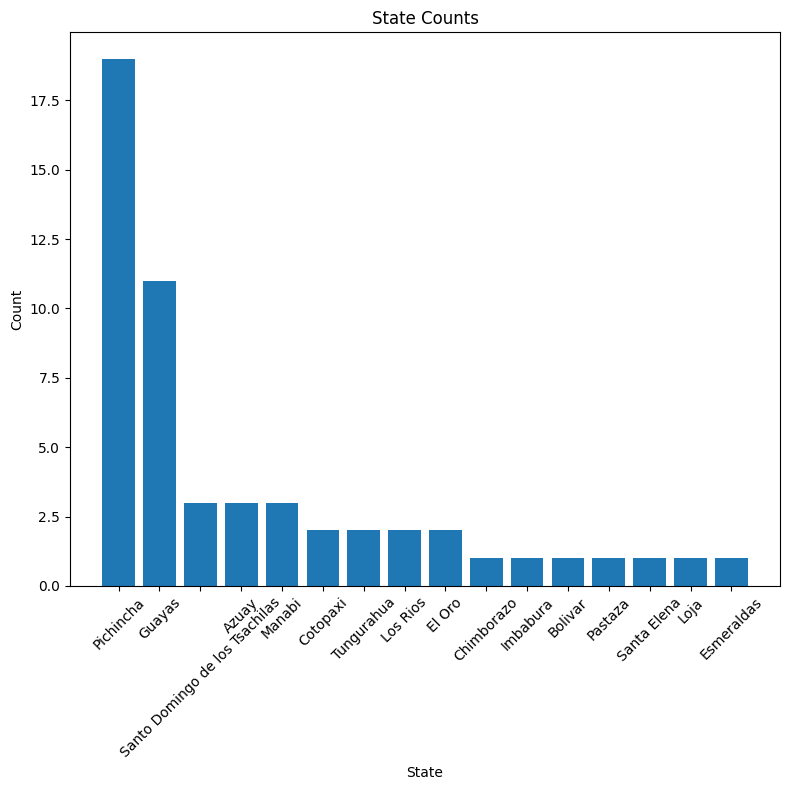

In [36]:
#Visualising the stores data set


# get the count of each state
state_counts = df_stores['state'].value_counts()

# plot the state counts
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(state_counts.index, state_counts.values)
ax.set_xlabel('State')
ax.set_ylabel('Count')
ax.set_title('State Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observations of the state column.**

-Pichincha has the highest number of favorita stores.
    
-Guayas has the second highest number of stores.

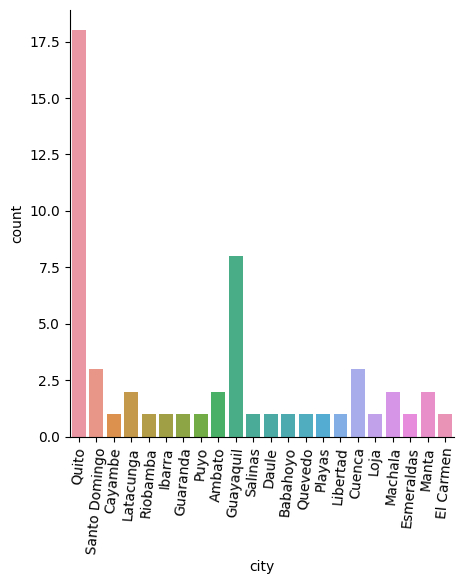

In [37]:
store_plot=sns.catplot(data=df_stores,x='city',kind='count',orient='h')
store_plot.ax.set_xticklabels(store_plot.ax.get_xticklabels(), rotation=85);

**Observations of the city column.**

-The city of Quito which is the capital of Ecuador has the highest number of favorita stores.

-Quito is located in the province of Pichincha this is consistent with the state visualization above.

-This is followed by Guayaquil located in the province of Guayas,this is also consistent with the observations from the state visualization.

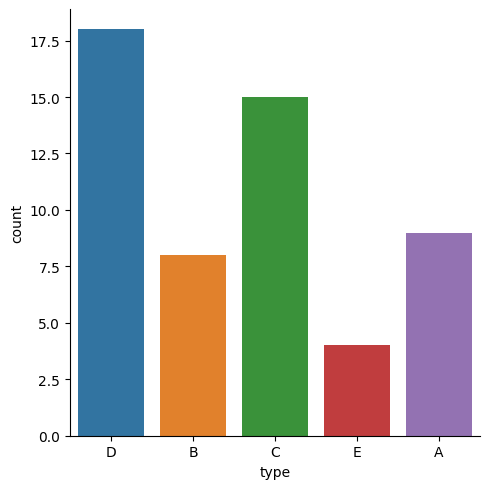

In [38]:
store_plot=sns.catplot(data=df_stores,x='type',kind='count',orient='h')
store_plot.ax.set_xticklabels(store_plot.ax.get_xticklabels());

**Observations of the store type column.**

-The dominant store type is the D followed by C and A type.

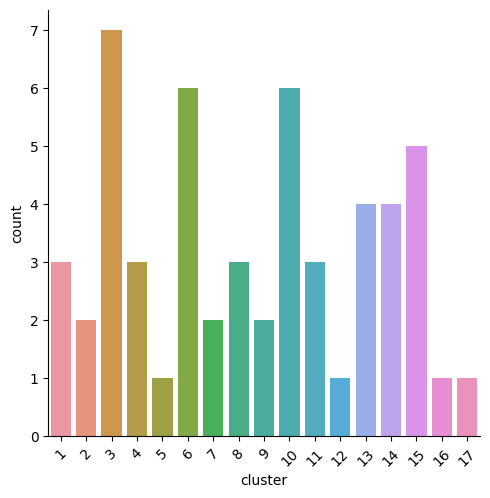

In [39]:
store_plot=sns.catplot(data=df_stores,x='cluster',kind='count',orient='h')
store_plot.ax.set_xticklabels(store_plot.ax.get_xticklabels(), rotation=45);

**Observations of the cluster column.**

-Cluster 3,6,10 and 15 are the dominant clusters respectively.

<b>TRANSACTIONS DATASET<b>

In [40]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [41]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [42]:
dfSummary(df_transactions,is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date[object],1. 2017-08-152. 2017-06-023. 2017-05-214. 2017-05-225. 2017-05-236. 2017-05-247. 2017-05-258. 2017-05-269. 2017-05-2710. 2017-05-2811. other,"54 (0.1%)54 (0.1%)54 (0.1%)54 (0.1%)54 (0.1%)54 (0.1%)54 (0.1%)54 (0.1%)54 (0.1%)54 (0.1%)82,948 (99.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,store_nbr[int64],Mean (sd) : 26.9 (15.6)min < med < max:1.0 < 27.0 < 54.0IQR (CV) : 27.0 (1.7),54 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACpklEQVR4nO3dMY7aQBiG4X/CggwoRogIOi4QKQUlTW6Qw6ZNlwIuwA1oEBIyRpBFgCFVUi5mBoM/8z712ljm9YzxWFp3uVwMKLtPzz4AII+3a3/gnGuaWcNz/4fL5fLuuS3w34ehOueavV7vRxzHXZ+dbzabxDn3k1jzCxwYzCo6OFwbURtxHHfH4/F7p9PZ37LjNE2jyWTSXa1WDTOr3IkrQujAYFbdweHq1G9m1ul09v1+/4/H/pse27wy74HBrNqDQ65Q8VgBA4NZRQcHfvVDAqFCAqFCAqFCAqFCAqFCQqGPp7Isq5tZ7Jzz3UUlV1nKqsyrYoWFutvt6sfj8dtwOKzVarWbH16bma3X661z7peZ+WwfdNJe7R2Hsq+KFRbq4XB4i6KoNRqN9oPBILl1+8Vi8Xk6nX4fDodffEIPOWkv+o5DqVfFCl+ZarfbXqssSZI0fUO/w0l72XccQlbFsiyLzf9W78NZqPRLqL6h2x2WEnnHIb/QW71rs1DpQ4WGkFu9PLMQoRYg4GlHfD6f6wUc0sMUNQMS6p2FTIHH4zHKsuzrfr//bWa+94mVvEgqG2rgM1zvLy1kCpzP593ZbNY6nU41n89+9kVSpEqGGnpjf48vzWcKTJIk6EfYMy+SolUy1NBnuGX/0q55xkVStEqG+k/IM9wijgf+eCkFEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEnL90940TaNbd7zdbiMzs91uFy2Xy9Yjt1f9bNXjDt0+T19/AW9vtspChyEjAAAAAElFTkSuQmCC"">",0(0.0%)
3,transactions[int64],Mean (sd) : 1694.6 (963.3)min < med < max:5.0 < 1393.0 < 8359.0IQR (CV) : 1033.0 (1.8),"4,993 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACg0lEQVR4nO3du47aQBSA4XPCggxIY1lE0PECkVJQ+iH2YdOmCxJPwBvQIVlcBDHBGKfaKptdfMvOcf6vn2GKX2CbsUaLohDAd58+egHAI57anFxVhyIyqDHFtSiKtKn1wK7WQlXV4WQyeXbORVXnOB6PO1X9Rqxo8xt14JyL4jhOwzC8lB18OByC1WoVJUkyEBFC/c+1+tMvIhKG4WU6nf6sOHzY6GJgFjdTMIFQYQKhwgRChQmEChMIFSYQKkwgVJhAqDCBUGECocIEQoUJhAoTCBUmECpMIFSYQKgwgVBhAqHCBEKFCYQKEwgVJhAqTCBUmECoMIFQYQKhwgRChQmEChMIFSYQKkwgVJhAqDCBUGECocIEQoUJrR82UUee530RcapaZThnVHWIt6Gez+d+lmVf5/N5r9frlT7+hzOqusXbUK/X61MQBKPFYnGZzWa7MmM5o6p7vA31xXg8rnpOFWdUdQg3UzCBUGECocIEQoUJ795MqepQRAYV5nb3+71fYRzwhzdDVdXhZDJ5ds5FZSfOsizI8/zL5XL5ISJVT5cGROT9b9SBcy6K4zgNw7DUQ/fNZhOt1+vR7Xbr1VgfICIPPkcNw7D0s8zdbsdzTDSGmymYQKgwwfu/UKuqufNKhN1XXulkqHV3Xomw+8o3nQy1zs4rEXZf+aiTob6osfNKhN1XXuFmCiYQKkwgVJjQ6WvUO

In [43]:
#Check for duplicate entries
df_transactions.duplicated().value_counts()

False    83488
dtype: int64

**Observations about Transactions dataset.**
    
-There are no duplicate entries.
 
-There are no null values.
    
-The date column is an object data type.

In [44]:
#Convert date from Object to Datetime

df_transactions['date']=pd.to_datetime(df_transactions.date)

**Feature Creation.**
    
For ease of analysis further down the line, I decided to create stand-alone columns for day,month and year using the date column.

In [45]:
date = pd.to_datetime(df_transactions['date'][0])

In [46]:
df_transactions['Year']=date.year
df_transactions['Month']=date.month
df_transactions['Day Name']=date.day_name()

In [47]:
#We now set the date as the index for the DataFrame

df_transactions = df_transactions.set_index('date')

In [48]:
df_transactions.head()

,store_nbr,transactions,Year,Month,Day Name
date,,,,,
2013-01-01,25,770,2013,1,Tuesday
2013-01-02,1,2111,2013,1,Tuesday
2013-01-02,2,2358,2013,1,Tuesday
2013-01-02,3,3487,2013,1,Tuesday
2013-01-02,4,1922,2013,1,Tuesday


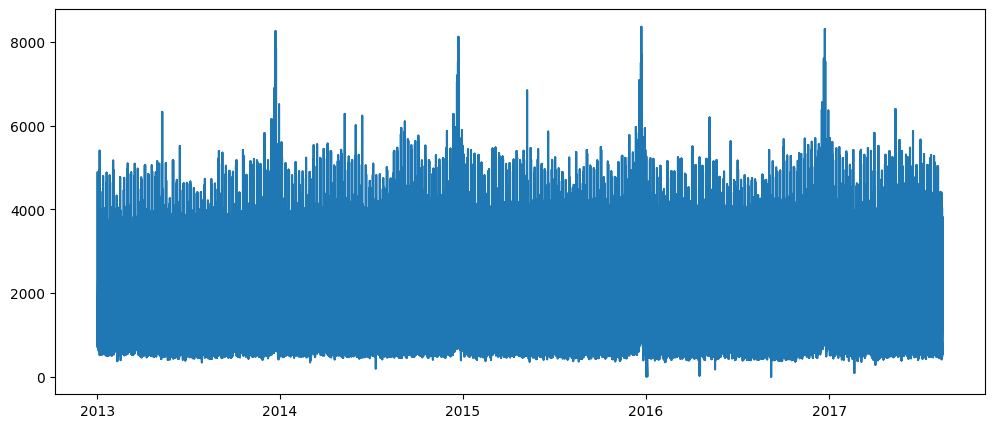

In [49]:
#Visualizing the transactions dataset
plt.figure(figsize=(12,5))
plt.plot(df_transactions.transactions);

-There is seasonality in transactions volumes across the years under review.

-The spike in transactions coincides with the shopping frenzy just before the christmas holidays.


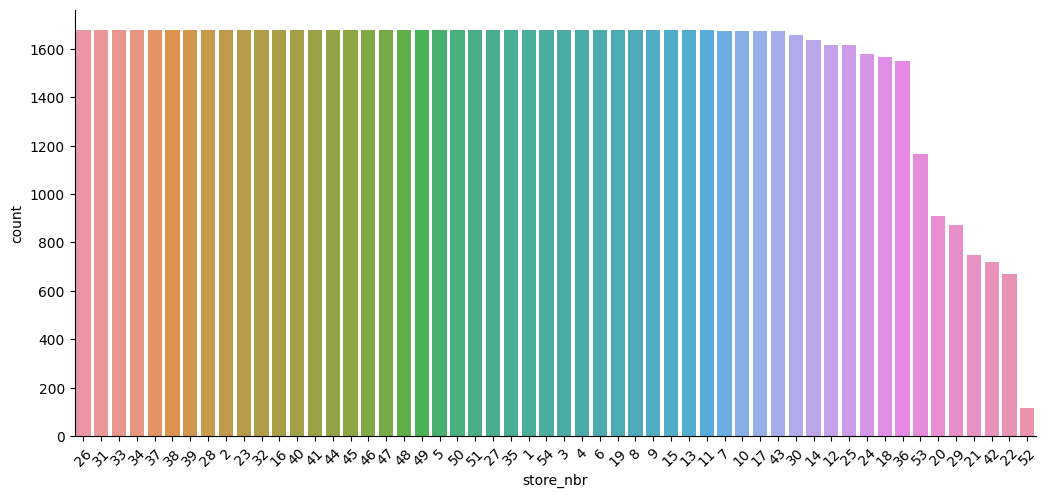

In [50]:
# group the data by store_nbr and count the values, then sort by the count values in descending order
store_counts = df_transactions.groupby('store_nbr')['store_nbr'].count().sort_values(ascending=False)

# create catplot with sorted data and order parameter
transaction_plot = sns.catplot(data=df_transactions, x='store_nbr', kind='count', orient='v', order=store_counts.index)

# adjust figure size
transaction_plot.fig.set_size_inches(12, 5)

# rotate x-axis labels if needed
transaction_plot.set_xticklabels(rotation=45)

# show plot
plt.show()

<b>TRAIN DATASET<b>

In [51]:
train_set.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [52]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [53]:
dfSummary(train_set,is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 1500443.5 (866281.9)min < med < max:0.0 < 1500443.5 < 3000887.0IQR (CV) : 1500443.5 (1.7),"3,000,888 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3XQU7CYBBA4fkbJSCkDSHCAbwBSw7hYT0EJ2DhxhU7EtKUUDEarCcAKTXqS963baczixcSUtM0If132V8fIF3i5rsXUkqDiOhd+f0sIj6vnO06T91Nvbvr/HvTNIdTD8+GmlIaTCaTxzzPx223Ho/H27quH0aj0UuWZR+/OU/dTb37J+Z3u12ZUno6Fet3v6i9PM/Hi8XiUBTFW5vF6/V6vFqt7ufz+fNsNivbzHadp+6m3t11vqqq/nK5HG+3215EXBVqREQURfE2nU5f2ywvy3IQETEcDlvPdp2n7qbe/RPzETE499A/U0IwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEK4eaSl6qq6rf98H6/70dE1HXd32w2d785T91Nvbvr/CV9fQGSljnmc7n3zQAAAABJRU5ErkJggg=="">",0(0.0%)
2,date[object],1. 2013-01-012. 2016-01-153. 2016-02-084. 2016-02-075. 2016-02-066. 2016-02-057. 2016-02-048. 2016-02-039. 2016-02-0210. 2016-02-0111. other,"1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)1,782 (0.1%)2,983,068 (99.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
3,store_nbr[int64],Mean (sd) : 27.5 (15.6)min < med < max:1.0 < 27.5 < 54.0IQR (CV) : 27.0 (1.8),54 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACW0lEQVR4nO3ZvYoaYQCF4fP5x/jDiEi0s0kZSGHpReRicwkpvAKLNKnsBBHFyYrjaJoNbLU6Mzu6B9+n9vM7LK8rarhcLgI+u9qjBwC3aFx7QAihLalV8PmPl8vlpeDZUkrulh603XW3VG0r74YaQmgPh8MfcRwPity82+02IYSf9/7Dld0tPWa7626p+lau/UdtxXE8mM1mL/1+/5Dn4u12G83n88F6vW5JuvcrvPBu6aHbXXdLFbdy9a1fkvr9/mE0Gv3Nc/mrdoEzH6bEbumB2113S9W1wocpWCBUWCBUWCBUWCBUWCBUWCBUWLjpe9SisixrSopDCEWfoibpXOBcfD6fm0UvlUpvf7bd0gdsf09loSZJ0kzT9PtkMqnX6/Xcv7JkWdZMkuRrr9f7U6vV0jxn0zSNsiz7djgcfknK/eVzme3PuFsqv/2aykI9Ho+NKIo60+n0MB6PN3nPL5fLwWKx+DKdTn/nPf96tnM6nep575XKbX/G3W/OF95+TaVv/ZLU7XYL/aS22WzaRc//P1tWmbufaffb81XhwxQsECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosECosNG550Ha7jfI+8X6/jyQpSZJotVp17nne9W7X3WXP39LXP+qZjcGrJz3hAAAAAElFTkSuQmCC"">",0(0.0%)
4,family[object],1. AUTOMOTIVE2. HOME APPLIANCES3. SCHOOL AND OFFICE SUPPLIES4. PRODUCE5. PREPARED FOODS6. POULTRY7. PLAYE

**Observations about the train dataframe.**

-There are no missing values in the dataFrame.

-The date column is an object data type.
    
-The family column are object data types this will not be accepted by the model.

In [54]:
#Convert date from object to date time.

train_set['date']=pd.to_datetime(train_set.date)

<Figure size 800x600 with 0 Axes>

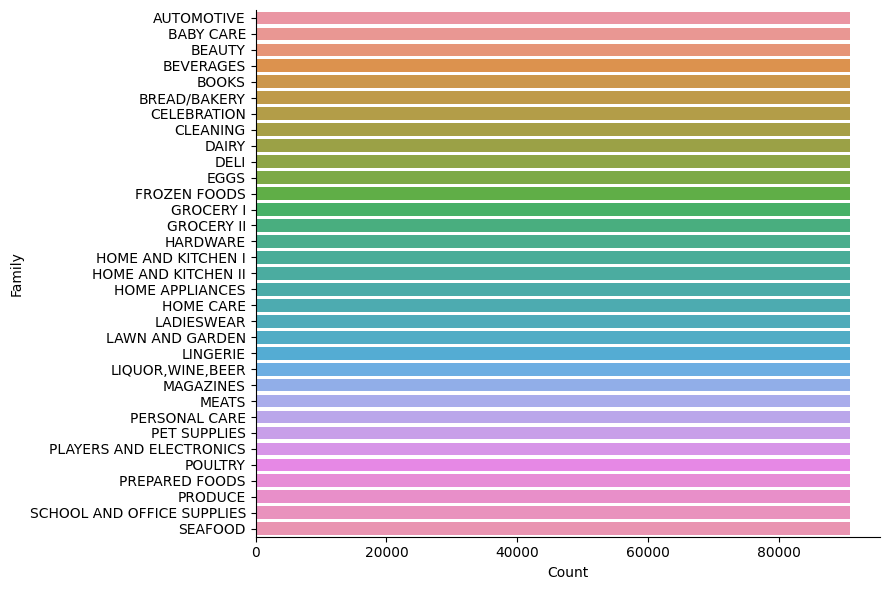

In [55]:
plt.figure(figsize=(8,6))
train_plot = sns.catplot(data=train_set, y='family', kind='count', orient='h', height=6, aspect=1.5)
train_plot.ax.set_xlabel('Count')
train_plot.ax.set_ylabel('Family');


**Observation about the Family column.**

-Alot of the family groupings are in the food category, these have to be regrouped for easier analyis.

-There is exactly the same number of entries for all product families in the train dataset.

<Axes: xlabel='date', ylabel='sales'>

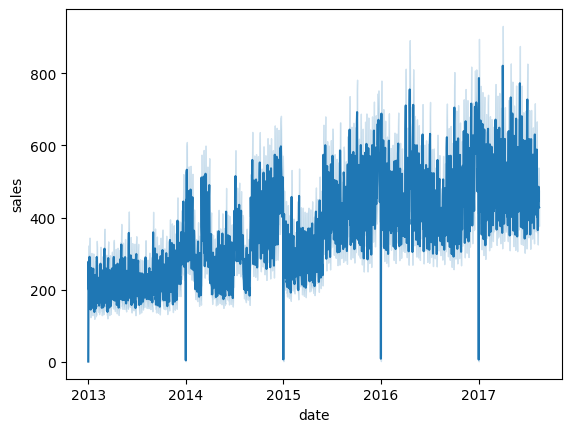

In [56]:
sns.lineplot(data=train_set, x='date', y='sales')

**Observation from the train_set transaction plot**.

-There is an upward trend in the transactions data.

-The transactions peak at the end of the year, then drops off. 

-There is a level of seasonality exhibited by the dataset.

-This indicates seasonality in the transactions data.

Observation of the dataset sales column.

-The highest obvervable spike in sales happened in the year 2014. Followed by 2015, 2016 and 2017 respectively.

# ANSWERING THE QUESTIONS.

**Q1.Is the train dataset complete (has all the required dates)?**

In [57]:
df=train_set

In [58]:
print(df.index.duplicated())

[False False False ... False False False]


In [59]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [60]:
#getting dates which are not in the train dataset
missing_dates=pd.date_range(start= '2013-01-01', end='2017-08-15').difference(df.date)


print(missing_dates);

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


<b>Q2.Which dates have the lowest and highest sales for each year?<b>
    
-Here the train_set DataFrame is used

In [61]:
# Group the dataframe by year and apply the calculation for each year
result = df.groupby(df['date'].dt.year).apply(lambda x: pd.Series({
    'max_sales_date': x.loc[x['sales'].idxmax(), 'date'],
    'max_sales_value': x.loc[x['sales'].idxmax(), 'sales'],
    'min_sales_date': x.loc[x['sales'].idxmin(), 'date'],
    'min_sales_value': x.loc[x['sales'].idxmin(), 'sales']
}))

print(result)


     max_sales_date  max_sales_value min_sales_date  min_sales_value
date                                                                
2013     2013-11-12        46271.000     2013-01-01              0.0
2014     2014-12-08        45361.000     2014-01-01              0.0
2015     2015-12-14        40351.460     2015-01-01              0.0
2016     2016-05-02       124717.000     2016-01-01              0.0
2017     2017-04-02        38422.625     2017-01-01              0.0


<b>Q3:Did the earthquake impact sales?<b>

In [62]:
#Set Date as the index for the df DataFrame
df = df.set_index('date')

In [63]:
df['Year']=date.year
df['Month']=date.month
df['Day Name']=date.day_name()

In [64]:
df.head()

,id,store_nbr,family,sales,onpromotion,Year,Month,Day Name
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,2013,1,Tuesday


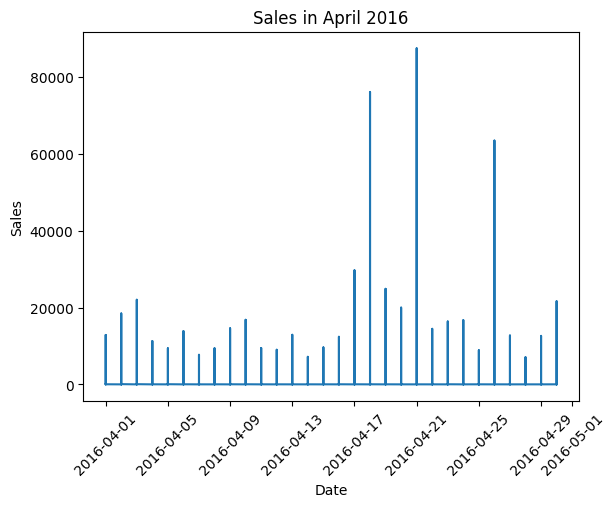

In [65]:
april_2016 = df.loc['2016-04-01':'2016-04-30']
plt.plot(april_2016.index, april_2016['sales'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales in April 2016')
plt.show()

Yes the earthquake had an impact on sales.
The earth quake occured on the 16th of April, looking at the chart it shows that sales increased to about 30000 on the 17th of April.
However, on the 18th of April, that is two (2) days after the earth quake sales shot up to 75000. This can be attributed to the after effect of the earth quake. Sales dropped to about 250000 on the 19th of April. 
There was a further jump in sales to about 87000 on the 21st of April and 62000 on the 26th of April, these sales jump can be attributed to the after effect earth quake. 

<b>Q4:Are certain groups of stores selling more products? (Cluster, city, state, type)<b>

In [66]:
#First merge the stores DataFrame and transactions DataFrame
performance_df=pd.merge(df_transactions,df_stores,on='store_nbr',how='outer')

<b>Analysing by city<b>

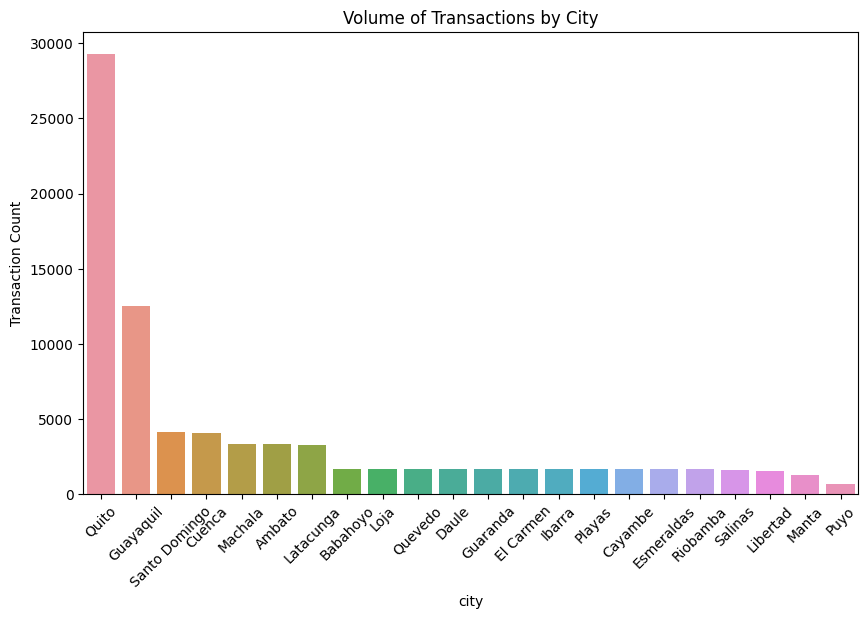

In [67]:
# group the data by city and count the values, then sort by the count values in descending order
city_counts = performance_df.groupby('city')['city'].count().sort_values(ascending=False)

# create a new figure object with the desired dimensions
plt.figure(figsize=(10, 6))

# create a count plot with the 'city' column on the x-axis and sorted data
sns.countplot(data=performance_df, x='city', order=city_counts.index)

# set the y-label
plt.ylabel('Transaction Count')

# set the title
plt.title('Volume of Transactions by City')

# rotate x-axis labels to make them readable
plt.xticks(rotation=45)

# show the plot
plt.show()


<b>Analysis of cluster perfromance<b>

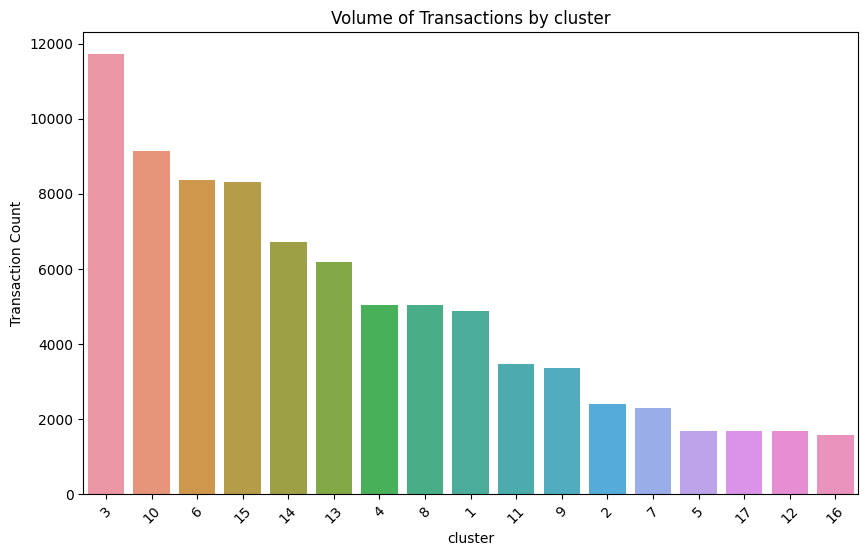

In [68]:
# group the data by city and count the values, then sort by the count values in descending order
city_counts = performance_df.groupby('cluster')['cluster'].count().sort_values(ascending=False)

# create a new figure object with the desired dimensions
plt.figure(figsize=(10, 6))

# create a count plot with the 'city' column on the x-axis and sorted data
sns.countplot(data=performance_df, x='cluster', order=city_counts.index)

# set the y-label
plt.ylabel('Transaction Count')

# set the title
plt.title('Volume of Transactions by cluster')

# rotate x-axis labels to make them readable
plt.xticks(rotation=45)

# show the plot
plt.show()


<b>Analysing sales by state<b>

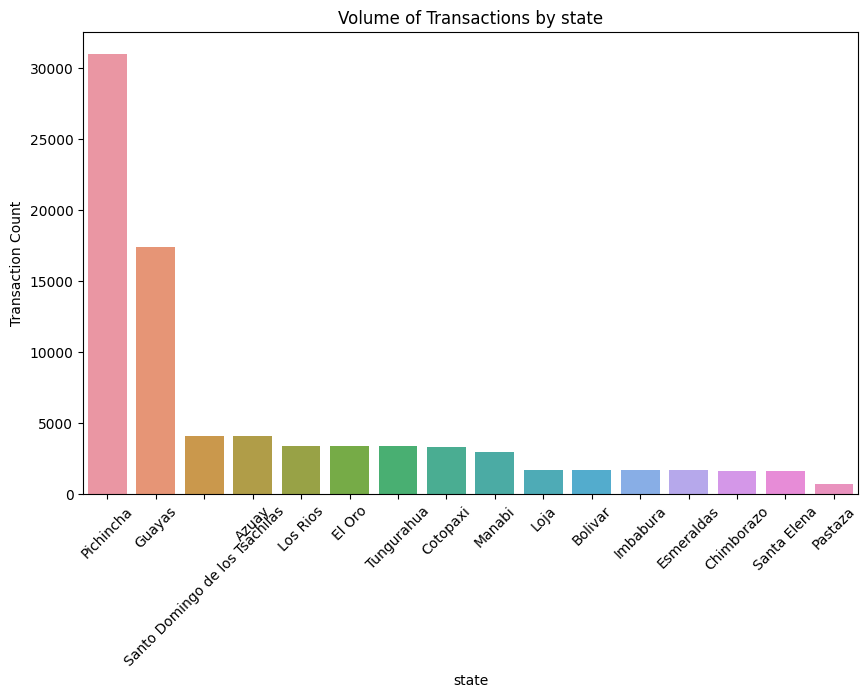

In [69]:
# group the data by city and count the values, then sort by the count values in descending order
city_counts = performance_df.groupby('state')['state'].count().sort_values(ascending=False)

# create a new figure object with the desired dimensions
plt.figure(figsize=(10, 6))

# create a count plot with the 'city' column on the x-axis and sorted data
sns.countplot(data=performance_df, x='state', order=city_counts.index)

# set the y-label
plt.ylabel('Transaction Count')

# set the title
plt.title('Volume of Transactions by state')

# rotate x-axis labels to make them readable
plt.xticks(rotation=45)

# show the plot
plt.show()


<b>Analysis by type<b>

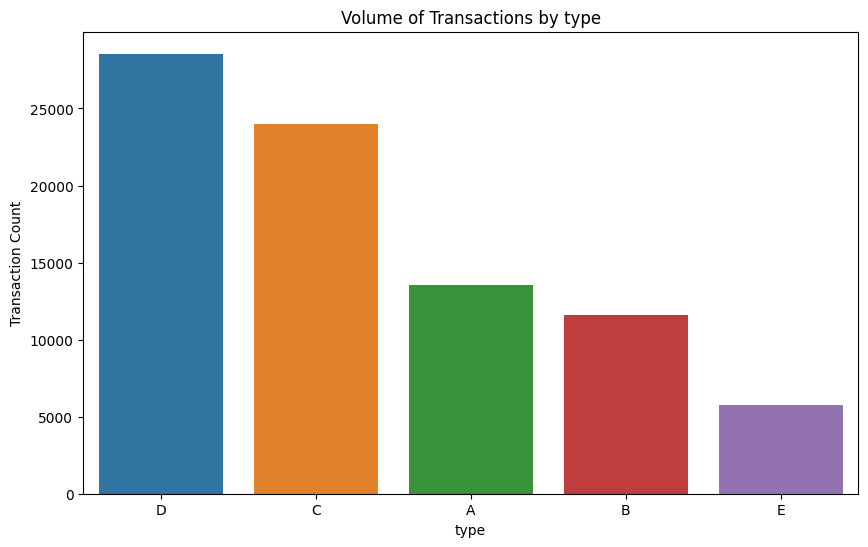

In [70]:
# group the data by city and count the values, then sort by the count values in descending order
city_counts = performance_df.groupby('type')['type'].count().sort_values(ascending=False)

# create a new figure object with the desired dimensions
plt.figure(figsize=(10, 6))

# create a count plot with the 'city' column on the x-axis and sorted data
sns.countplot(data=performance_df, x='type', order=city_counts.index)

# set the y-label
plt.ylabel('Transaction Count')

# set the title
plt.title('Volume of Transactions by type')

# show the plot
plt.show()


<b>Q5:Are sales affected by promotions, oil prices and holidays?<b>

<b>Sales Vrs promotions Analysis<b>

In [71]:
#Merge the train_set,oil and holiday events DataFrames

new_train=pd.merge(train_set,df_oil,left_on=['date'],right_on=['date'],how='inner').merge(df_holiday_events,on=['date'],how='inner')

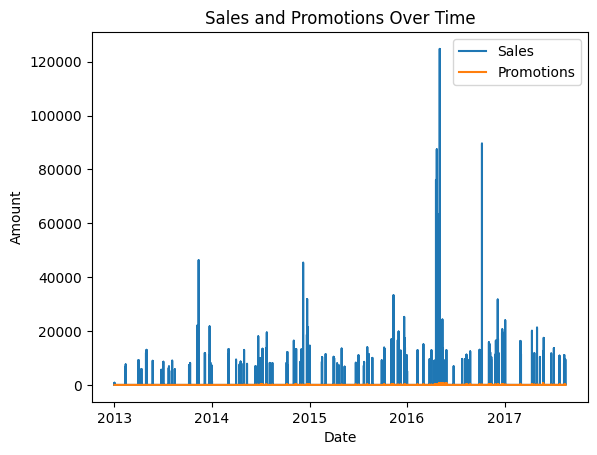

In [72]:
# plot sales and promotions against dates
plt.plot(new_train['date'], new_train['sales'], label='Sales')
plt.plot(new_train['date'], new_train['onpromotion'], label='Promotions')

# add title and axis labels
plt.title('Sales and Promotions Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')

# add legend
plt.legend()

# display the plot
plt.show()


In [73]:
# compute correlation between sales and promotions
corr = df['sales'].corr(df['onpromotion'])

# correlation coefficient
print(f"Correlation coefficient between sales and promotions: {corr:.2f}")


Correlation coefficient between sales and promotions: 0.43


A correlation coefficient of 0.43 indicates a moderate positive correlation between the two variables being compared.

In this case, the two variables are sales and promotions, a correlation coefficient of 0.43 suggests that there is a moderate positive relationship between the amount of promotions and the amount of sales. This means that as the amount of promotions increases, the amount of sales tends to increase as well, but not necessarily in a linear fashion.

<b>Sales vrs Oil<b>

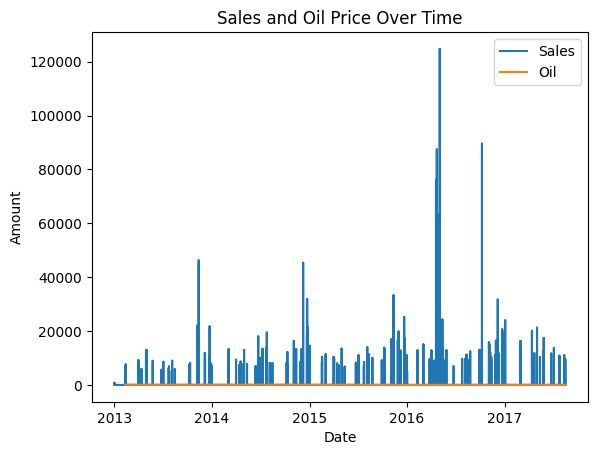

In [74]:
# plot sales and oil prices against dates
plt.plot(new_train['date'], new_train['sales'], label='Sales')
plt.plot(new_train['date'], new_train['dcoilwtico'], label='Oil')

# add title and axis labels
plt.title('Sales and Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')

# add legend
plt.legend()

# display the plot
plt.show()

In [75]:
# compute correlation between sales and promotions
corr = new_train['sales'].corr(new_train['dcoilwtico'])

# correlation coefficient
print(f"Correlation coefficient between sales and oil price: {corr:.2f}")

Correlation coefficient between sales and oil price: -0.07


A correlation coefficient of -0.07 suggests a weak negative correlation between the two variables being compared.
The negative sign indicates that there is a negative relationship between the two variables, meaning that as one variable increases, the other tends to decrease, although the correlation is weak, which suggests that the relationship is not very strong.

<b>Sales Vrs Holidays<b>

In [76]:
holiday_sales = new_train.groupby('type')['sales'].sum().reset_index()
holiday_sales['Cumulative_Percentage'] = (holiday_sales['sales'].cumsum() / holiday_sales['sales'].sum()) * 100
holiday_sales = holiday_sales.sort_values(by='sales', ascending=False)

holiday_sales

,type,sales,Cumulative_Percentage
3,Holiday,7.525080e+07,94.916414
2,Event,2.511684e+07,37.425222
0,Additional,2.148108e+07,16.411428
4,Transfer,6.653957e+06,100.000000
1,Bridge,2.388330e+06,18.236099


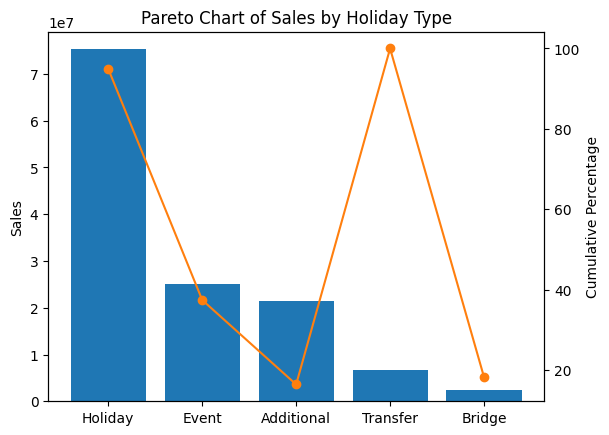

In [77]:
fig, ax1 = plt.subplots()
ax1.bar(holiday_sales['type'], holiday_sales['sales'], color='C0')
ax1.set_ylabel('Sales')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(holiday_sales['type'], holiday_sales['Cumulative_Percentage'], color='C1', marker='o')
ax2.set_ylabel('Cumulative Percentage')
ax2.tick_params(axis='y')

plt.title('Pareto Chart of Sales by Holiday Type')
plt.show()

In [78]:
import scipy.stats as stats

# Group the data by type of holiday
groups = new_train.groupby('type')['sales'].apply(list)

# Perform ANOVA test
f_value, p_value = stats.f_oneway(*groups)

print(f"One-way ANOVA results: F = {f_value:.2f}, p-value = {p_value:.4f}")


One-way ANOVA results: F = 194.19, p-value = 0.0000


Based on the results of the ANOVA test, we can conclude that there is a significant difference in sales between the different types of holidays. This means that the type of holiday has an impact on the sales. However, the ANOVA test does not tell us which specific type of holiday is responsible for the difference in sales. To determine that, we would need to perform additional analyses such as post-hoc tests or pairwise comparisons.

<b>Q6:What analysis can we get from the date and its extractable features?<b>

**The extractable features from the date are Year,Month and Day.** 

**Year**:At the high level we can analyse the sales performance across the years for a specific store,city, state, product family or cluster.
    
**Month**: The next level of drill down will be analysing sales performance monthly for stors,cities, states, product families and clusteres. The analysis can cover corresponding months acoss years that is you can analyse sales in the month of January for all years. This will show whether there is seasonality or not.
    
**Day of week**: Day of week provides a further level of detail to the analysis that can be done.<b>

<b>MODELLING AND PREDICTIONS<b>

**FB PROPHET MODEL**

The first model for prediction is the prophet model from Facebook

In [79]:
#Read in the train_data specifically for the prophet model
#We restricted the columns to only the sales and date.

train_set_pr=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/train.csv",usecols=['date','sales'])

In [80]:
train_set_pr.head()

,date,sales
0,2013-01-01,0.0
1,2013-01-01,0.0
2,2013-01-01,0.0
3,2013-01-01,0.0
4,2013-01-01,0.0


In [81]:
#We check the size and memory required for the train_set_pr DataFrame

train_set_pr.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   sales   float64
dtypes: float64(1), object(1)
memory usage: 214.6 MB


In [82]:
#To use the forest model, the columns names for date and sales have to be changed to ds and y respectively
train_set_pr.columns=['ds','y']

In [83]:
train_set_pr.head()

,ds,y
0,2013-01-01,0.0
1,2013-01-01,0.0
2,2013-01-01,0.0
3,2013-01-01,0.0
4,2013-01-01,0.0


In [84]:
#The notebook kept crashing when we tried to train the model. We therefore decided to use only one million rows from the DataFrame of three million rows.

sample_data=train_set_pr.sample(n=1000000)

In [85]:
#The model is named 'model'

model=Prophet()

In [86]:
#Training the model

model.fit(sample_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ntcm0s0/n0fqcxkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ntcm0s0/1zq1dmpa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18901', 'data', 'file=/tmp/tmp3ntcm0s0/n0fqcxkw.json', 'init=/tmp/tmp3ntcm0s0/1zq1dmpa.json', 'output', 'file=/tmp/tmp3ntcm0s0/prophet_modeliu6gn7i3/prophet_model-20230430121141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:11:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [87]:
#Create future dates over a period of year which will be used to make predictions using the model.

future_dates=model.make_future_dataframe(periods=365)

In [88]:
#Make predictions using the model

prediction=model.predict(future_dates)

In [89]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,162.983363,-1195.939077,1542.120549,162.983363,162.983363,23.101751,23.101751,23.101751,-36.884560,-36.884560,-36.884560,59.986312,59.986312,59.986312,0.0,0.0,0.0,186.085115
1,2013-01-02,163.405204,-1127.113875,1659.282970,163.405204,163.405204,30.872002,30.872002,30.872002,-23.282314,-23.282314,-23.282314,54.154315,54.154315,54.154315,0.0,0.0,0.0,194.277205
2,2013-01-03,163.827044,-1313.194122,1525.956002,163.827044,163.827044,-28.090379,-28.090379,-28.090379,-76.429221,-76.429221,-76.429221,48.338842,48.338842,48.338842,0.0,0.0,0.0,135.736665
3,2013-01-04,164.248884,-1198.539734,1523.933377,164.248884,164.248884,11.348870,11.348870,11.348870,-31.285417,-31.285417,-31.285417,42.634287,42.634287,42.634287,0.0,0.0,0.0,175.597754
4,2013-01-05,164.670724,-1105.550453,1672.730289,164.670724,164.670724,111.947383,111.947383,111.947383,74.818342,74.818342,74.818342,37.129042,37.129042,37.129042,0.0,0.0,0.0,276.618108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,2018-08-11,565.193821,-886.828335,1970.746698,90.842301,1012.881045,23.027276,23.027276,23.027276,74.818342,74.818342,74.818342,-51.791066,-51.791066,-51.791066,0.0,0.0,0.0,588.221097
2045,2018-08-12,565.368647,-854.701917,1940.485477,89.737867,1015.101668,54.480729,54.480729,54.480729,106.795789,106.795789,106.795789,-52.315060,-52.315060,-52.315060,0.0,0.0,0.0,619.849376
2046,2018-08-13,565.543473,-944.160485,2072.295804,88.633433,1016.777868,-66.199693,-66.199693,-66.199693,-13.732619,-13.732619,-13.732619,-52.467074,-52.467074,-52.467074,0.0,0.0,0.0,499.343780
2047,2018-08-14,565.718299,-1152.084286,1903.065589,86.475310,1018.454068,-89.130866,-89.130866,-89.130866,-36.884560,-36.884560,-36.884560,-52.246306,-52.246306,-52.246306,0.0,0.0,0.0,476.587433


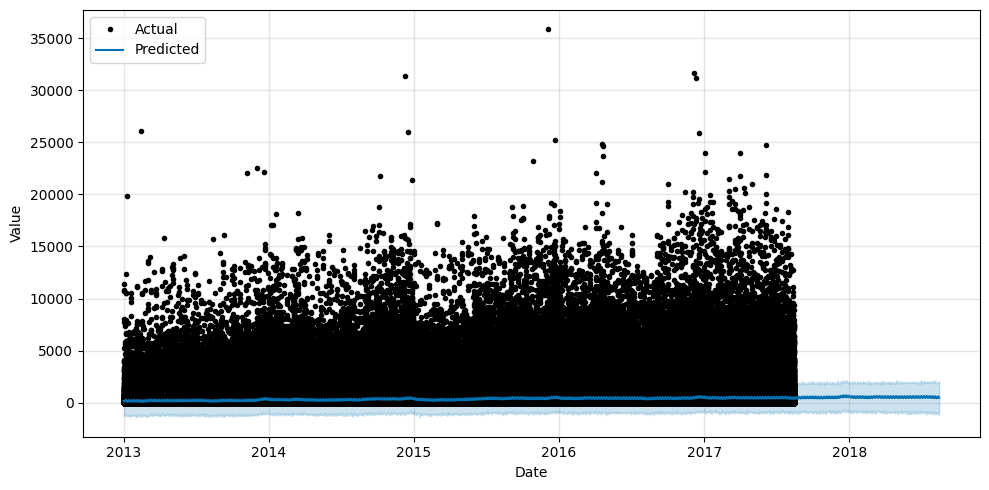

In [90]:
#Visualize the results to show the actual and predicted sales

fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(prediction, ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

ax.legend(['Actual', 'Predicted'], loc='upper left')

plt.show()


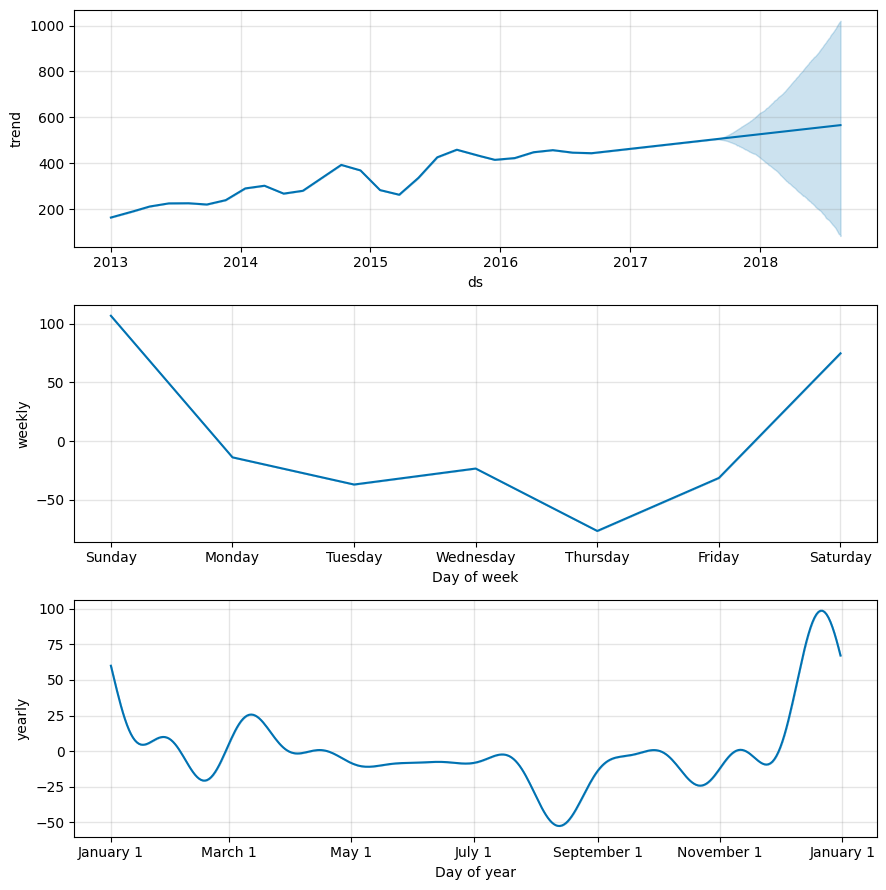

In [91]:
#Prophet model allows for visualising the 'headline' trend,weekly trend and yearly trend.

fig=model.plot_components(prediction)
plt.show()

#**Observations**

-Trend: The highlevel trend indicates a positive growth in sales from 2013 to 2017 onwards. 2018 represents predicted sales with confidence interval.

-Weekly trend analysis shows that sales jumps exponentially from Thursday towards the weekend. This implies customers make their purchases close to the weekend.

-The monthly data indicates seasonality in the trend. From November when shopping towards Christmas festivities happen,we notice a rise in sales till the new year on 1st January. Sales then level of for the rest of the year till another November comes around.

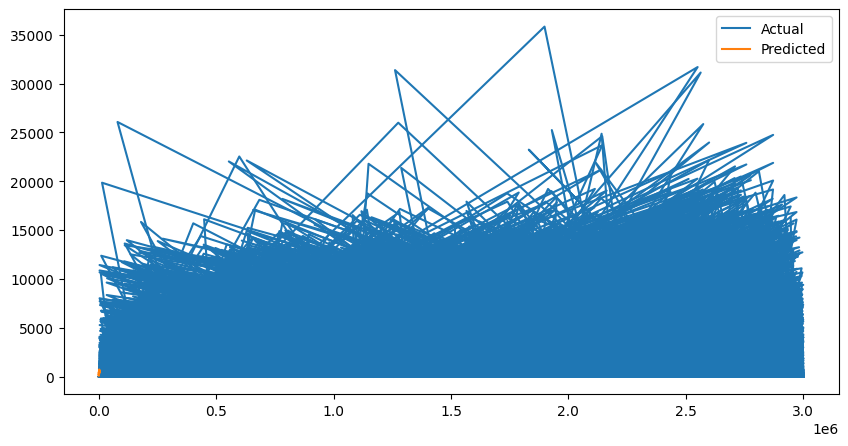

In [92]:
# Plot actual and predicted values

plt.rcParams['agg.path.chunksize'] = 1000

plt.figure(figsize=(10, 5))
plt.plot(sample_data.index, sample_data['y'], label='Actual')
plt.plot(prediction.index, prediction['yhat'], label='Predicted')
plt.legend()
plt.show()


# **ARIMA MODEL**

In [93]:
train_ar=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/train.csv')
test_ar=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/test.csv')

In [94]:
#Change the date format from object to datetime
train_ar['date'] = pd.to_datetime(train_ar['date'])
test_ar['date'] = pd.to_datetime(test_ar['date'])

In [95]:
#Set the date as the index for both datasets

train_ar = train_ar.set_index('date')
test_ar= test_ar.set_index('date')

In [96]:
train_ar.drop(['id','family'], axis=1, inplace=True)

In [ ]:
train_ar.drop(['store_nbr'], axis=1, inplace=True)

<Axes: xlabel='date'>

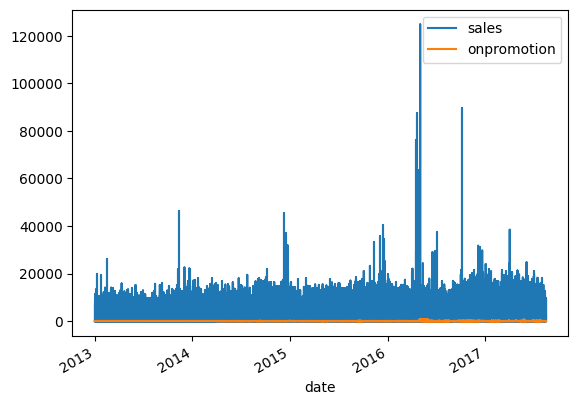

In [98]:
train_ar.plot()

In [99]:
# Fit ARIMA model
model_ar = ARIMA(train_ar['sales'], order=(1,1,1))
model_fit_ar = model_ar.fit()

In [100]:
# Make predictions on the test set
test_ar['predicted_sales'] = model_fit_ar.forecast(steps=len(test_ar))


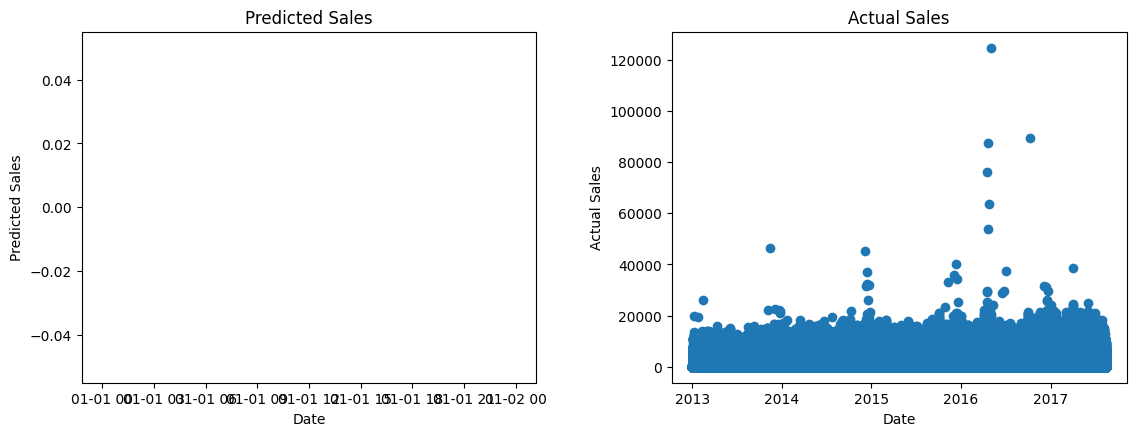

In [113]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# Plot predicted sales in test data
ax[0].scatter(test_ar.index, test_ar['predicted_sales'])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Predicted Sales')
ax[0].set_title('Predicted Sales')

# Plot actual sales in train data
ax[1].scatter(train_ar.index, train_ar['sales'])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Actual Sales')
ax[1].set_title('Actual Sales')

# Create space between the two subplots
fig.tight_layout(pad=3.0)

# Show the plot
plt.show()



**LINEAR REGRESSION**

In [102]:
train_lr=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/train.csv')
test_lr=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AZUBI-LP2/test.csv')

In [103]:
test_lr.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [104]:
#Change the date format from object to datetime
train_lr['date'] = pd.to_datetime(train_lr['date'])
test_lr['date'] = pd.to_datetime(test_lr['date'])

In [105]:
#Set the date as the index for both datasets

train_lr = train_lr.set_index('date')
test_lr= test_lr.set_index('date')

In [106]:
# Define the dependent and independent variables
X_train = train_lr[['onpromotion']]
y_train = train_lr['sales']
x_test=test_lr[['onpromotion']]


In [107]:
# Train linear regression model on train data
lr_model = LinearRegression()

In [108]:
#Training the model
lr_model.fit(X_train, y_train)

LinearRegression()

In [109]:
#Predict the sales for the test data

y_test_pred = lr_model.predict(x_test)

In [110]:
# Add predicted sales column to test data
test_lr['predicted_sales'] = y_test_pred

**VISUALISING THE ACTUAL SALES VRS PREDICTED SALES**

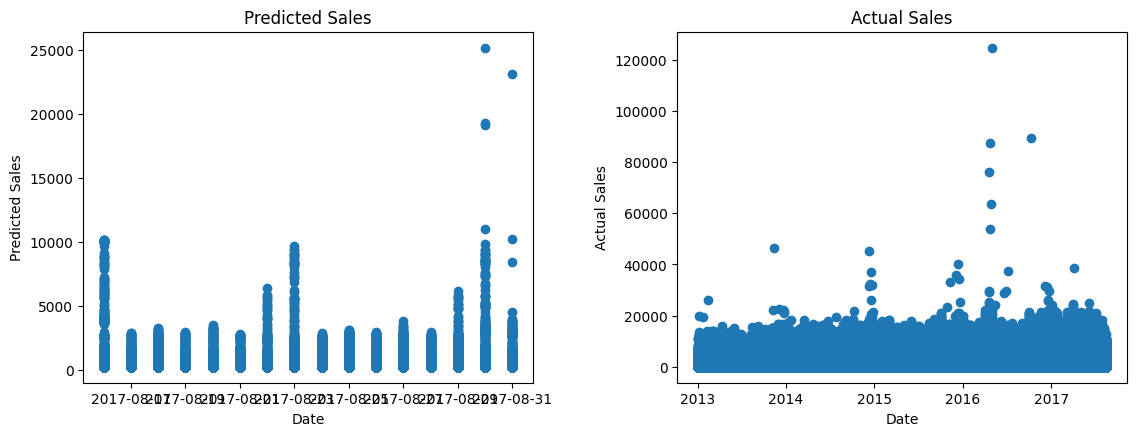

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# Plot predicted sales in test data
ax[0].scatter(test_lr.index, test_lr['predicted_sales'])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Predicted Sales')
ax[0].set_title('Predicted Sales')

# Plot actual sales in train data
ax[1].scatter(train_lr.index, train_lr['sales'])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Actual Sales')
ax[1].set_title('Actual Sales')

# Create space between the two subplots
fig.tight_layout(pad=3.0)

# Show the plot
plt.show()
